# Radiaoctivity

## 1. Introduction

**Radioactivity** is the physical *phenomenon* by which the nuclei of unstable atoms (called *radioisotopes* or *radionuclides*) spontaneously transform into different atoms, emitting radiation in the process.

This transformation process is called **radioactive decay**.

There are different types of radiation emitted during radioactive decay:

- **Alpha particle** (α):  Emission of the nucleus of a helium atom (He²⁺), consisting of 2 protons and 2 neutrons. Alpha radiation has low penetration power but high ionizing power.
- **Beta particle**  (β): Emission of an electron or positron. Beta radiation has greater penetration than alpha particles but moderate ionizing power.
- **Gamma** radiation (γ): Emission of high-energy electromagnetic waves. Gamma rays have very high penetration power but low ionizing power.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import brentq

# -----------------------------------------------------------------------------
# 1. Global Definitions and Parameters (in atomic units)
# -----------------------------------------------------------------------------

ALPHA_MASS_AU = 7294.0     # alpha particle mass in me
AU_TIME_TO_S = 1  # 1 a.u. of time -> seconds
AU_TIME_TO_S = 2.418884e-17  # 1 a.u. of time -> seconds: Atomic unit of time to seconds conversion

# -----------------------------
# Input Parameters
# -----------------------------
element_data = {
    "Po-210": {"Z": 84, "E_MeV": 5.3, "V0_MeV": 40, "R0_fm": 7.14, "a_fm": 0.65,"l_orbital": 0, "r_min": 1e-6, "r_max": 5e-3},
    "Po-210_2": {"Z": 84, "E_MeV": 15.0, "V0_MeV": 117, "R0_fm": 7.25, "a_fm": 0.69,"l_orbital": 0, "r_min": 1e-6, "r_max": 5e-3},
    
    "Ra-226": {"Z": 88, "E_MeV": 4.78, "V0_MeV": 40, "R0_fm": 7.0, "a_fm": 0.65, "l_orbital": 0, "r_min": 1e-6, "r_max": 5e-3},
    "Ra-226_2": {"Z": 88, "E_MeV": 4.87, "V0_MeV": 117, "R0_fm": 7.25, "a_fm": 0.688, "l_orbital": 0, "r_min": 1e-6, "r_max": 5e-3},
    
    "U-238": {"Z": 92, "E_MeV": 4.3, "V0_MeV": 50, "R0_fm": 5.1, "a_fm": 0.65, "l_orbital": 0, "r_min": 1e-6, "r_max": 5e-3},
    "U-238_2": {"Z": 92, "E_MeV": 4.19, "V0_MeV": 117, "R0_fm": 7.25, "a_fm": 0.65, "l_orbital": 0, "r_min": 1e-6, "r_max": 5e-3},
    
    "Th-232": {"Z": 90, "E_MeV": 4.1, "V0_MeV": 50, "R0_fm": 5.05, "a_fm": 0.65, "l_orbital": 0, "r_min": 1e-6, "r_max": 5e-3}
}


# Z_parent    = 88          # parent nucleus charge (Radium)
# E_hartree   = 1.79e5      # alpha particle energy for Radium (Hartree) ~ 5 MeV => ~ 1.84e5 Hartree
# V0_hartree  = 4.3e6       # Woods-Saxon depth ~ 50 MeV => ~ 1.84e6 Hartree
# R0_bohr     = 13.7e-5     # ~ 5 fm => ~ 9.45e-5 Bohr
# a_bohr      = 1.3e-5      # diffuseness (Bohr) ~ 0.65 fm => ~ 1.23e-5 Bohr
# l_orbital   = 0           # orbital angular momentum
# r_min       = 1e-6        # inner bohr-radius
# r_max       = 5e-3        # outer bohr-radius
# N           = 2000        # number of points for scanning turning points


# Z_parent    = 92          # parent nucleus charge (Uranium)
# E_hartree   = 1.54e5      # alpha particle energy for Uranium (Hartree) ~ 5 MeV => ~ 1.84e5 Hartree
# V0_hartree  = 4.3e6       # Woods-Saxon depth ~ 50 MeV => ~ 1.84e6 Hartree
# R0_bohr     = 13.7e-5     # ~ 5 fm => ~ 9.45e-5 Bohr
# a_bohr      = 1.3e-5      # diffuseness (Bohr) ~ 0.65 fm => ~ 1.23e-5 Bohr
# l_orbital   = 0           # orbital angular momentum
# r_min       = 1e-6        # inner bohr-radius
# r_max       = 5e-3        # outer bohr-radius
# N           = 2000        # number of points for scanning turning points


# Unit conversions
def MeV_to_Hartree(MeV): return MeV * 36749.7
def fm_to_Bohr(fm): return fm * 1.8897e-5

# Choose element : Polonium - "Po-210", 
#                  Radium   - "Ra-226"
#                  Uranium  - "U-238", 
#                  Thorium  - "Th-232"

element = "U-238_2"

# Load parameters from dictionary
params = element_data[element]

#Apply to your global variables
Z_parent    = params["Z"]                       # Parent nucleus charge
E_hartree   = MeV_to_Hartree(params["E_MeV"])   # Alpha particle energy
V0_hartree  = MeV_to_Hartree(params["V0_MeV"])  # Depth of nuclear potential well, usually in the range of 40 to 60 MeV for heavy nuclei.
R0_bohr     = fm_to_Bohr(params["R0_fm"])       # Nuclear radius in femtometers (fm). R0≈1.2×A^(1/3) fm => where A is the mass number. Need to be adjusted.
a_bohr      = fm_to_Bohr(params["a_fm"])        # diffuseness (Bohr): Physically, it's the distance over which the nuclear potential drops from ~90% of V0 to ~10%.

l_orbital   = params["l_orbital"]               # Orbital angular momentum of alpha particle
r_min       = params["r_min"]                   # inner bohr-radius
r_max       = params["r_max"]                   # outer bohr-radius
N           = 2000                              # number of points for scanning turning points

# Optional: print to confirm
print(f"Loaded parameters for {element}:")
print(f"  Z_parent = {Z_parent}, E_hartree = {E_hartree:.2e} Ha, V0_hartree = {V0_hartree:.2e} Ha, R0_bohr = {R0_bohr:.2e} Bohr, a_bohr = {a_bohr:.2e} Bohr")


Loaded parameters for U-238_2:
  Z_parent = 92, E_hartree = 1.54e+05 Ha, V0_hartree = 4.30e+06 Ha, R0_bohr = 1.37e-04 Bohr, a_bohr = 1.23e-05 Bohr


Troubleshooting Info:
  r_min = 1e-06, r_max = 0.005
  V_min over this range = -2.2602e+06 Hartree
  V_max over this range = 1.7970e+08 Hartree
  E (alpha energy)      = 1.5398e+05 Hartree

Sample checks of sign(E - V(r)) at a few points:
  r=1.0000e-06, V(r)=1.7970e+08, E-V=-1.7955e+08 (-)
  r=2.5018e-03, V(r)=7.3549e+04, E-V=8.0433e+04 (+)
  r=5.0000e-03, V(r)=3.6800e+04, E-V=1.1718e+05 (+)

-- Attempting to detect barrier & compute WKB --
Turning points found (Bohr radii): [4.133052243633568e-05, 0.00015060735148540304, 0.00119495073825323]
Barrier region: r_in=1.5061e-04, r_out=1.1950e-03

-- Results --
WKB barrier integral = 4.845199e+01
Tunneling probability = 8.225e-43
Well region: r_a=4.1331e-05, r_b=1.5061e-04
Classical period T_au = 1.3656e-05 => T_s=3.3033e-22 s
Decay rate Gamma = 2.4900e-21 s^-1
Half-life t_1/2 = 2.7838e+20 s


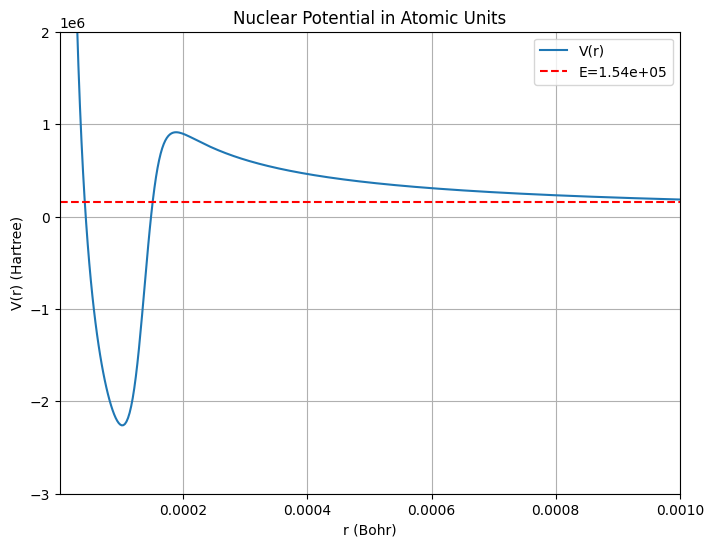

In [16]:

# -----------------------------------------------------------------------------
# 2. Potential: Woods-Saxon + Coulomb in a.u.
# -----------------------------------------------------------------------------
def V_WS_Coulomb_au(r, V0, R0, a, Z_nuc, Zalpha=2, mass_alpha=ALPHA_MASS_AU, l=0):
    """
    Woods-Saxon + Coulomb + optional centrifugal term in atomic units.
    """
    if r < 1e-12:
        r = 1e-12
    
    # Woods-Saxon
    Vws = -V0 / (1.0 + np.exp((r - R0)/a))
    # Coulomb
    Vcoul = Zalpha * Z_nuc / r
    # Centrifugal
    Vcentrif = l*(l+1)/(2.0*mass_alpha*r*r)
    return Vws + Vcoul + Vcentrif

# Potential Wrapper
def potential_au(r):
    return V_WS_Coulomb_au(r,
                           V0=V0_hartree,
                           R0=R0_bohr,
                           a=a_bohr,
                           Z_nuc=Z_parent,
                           Zalpha=2,
                           mass_alpha=ALPHA_MASS_AU,
                           l=l_orbital)

# -----------------------------------------------------------------------------
# 3. WKB and Classical Integrand Functions
# -----------------------------------------------------------------------------
def forbidden_integrand(r, E, m_alpha, pot_func):
    """
    Calculates the square root for the WKB integral
    sqrt(2*m_alpha*(V(r)-E)) if V(r)>E, else 0
    """
    val = pot_func(r) - E
    return np.sqrt(2*m_alpha*val) if val > 0 else 0.0

def classical_integrand(r, E, m_alpha, pot_func):
    """
    Calculates inverse velocity in the classical region
    1 / v(r) = sqrt(m_alpha/(2*(E - V(r)))) if E>V(r), else 0
    """
    val = E - pot_func(r)
    return np.sqrt(m_alpha/(2*val)) if val > 0 else 0.0

# -----------------------------------------------------------------------------
# 4. Helper Functions
# -----------------------------------------------------------------------------
def find_turning_points(r_min, r_max, E, pot_func, N=2000):
    r_vals = np.linspace(r_min, r_max, N)
    diff = E - np.array([pot_func(rv) for rv in r_vals])
    
    turning_pts = []
    for i in range(len(r_vals)-1):
        if diff[i]*diff[i+1] < 0:
            root = brentq(lambda rr: E - pot_func(rr), r_vals[i], r_vals[i+1])
            turning_pts.append(root)
    turning_pts.sort()
    return turning_pts

def detect_barrier_hill(E, turning_points, r_min, r_max, pot_func):
    """
    Looks for the pattern (+)->(-)->(+) in E-V(r)
    Returns the last such (r_in, r_out) if found
    """
    boundaries = [r_min] + turning_points + [r_max]
    signs = []
    for i in range(len(boundaries)-1):
        mid = 0.5*(boundaries[i] + boundaries[i+1])
        val_mid = E - pot_func(mid)
        s = 1 if val_mid > 0 else -1
        signs.append(s)
    
    hill_intervals = []
    for i in range(len(signs)-2):
        if signs[i] == 1 and signs[i+1] == -1 and signs[i+2] == 1:
            hill_start = boundaries[i+1]
            hill_end   = boundaries[i+2]
            hill_intervals.append((hill_start, hill_end))
    
    if hill_intervals:
        return hill_intervals[-1]
    return None

def compute_WKB_barrier_integral(r_in, r_out, E, m_alpha, pot_func):
    val, _ = quad(lambda rr: forbidden_integrand(rr, E, m_alpha, pot_func),
                  r_in, r_out, epsabs=1e-12, epsrel=1e-12, limit=1000)
    return val

def find_well_region(E, turning_points, r_min, r_max, pot_func):
    """
    Finds the first sub-interval [r_a, r_b] where E>V(r)
    """
    boundaries = [r_min] + turning_points + [r_max]
    for i in range(len(boundaries)-1):
        left = boundaries[i]
        right = boundaries[i+1]
        mid = 0.5*(left + right)
        if (E - pot_func(mid)) > 0:
            return (left, right)
    return None

def compute_classical_period(r_a, r_b, E, m_alpha, pot_func):
    single_trip, _ = quad(lambda rr: classical_integrand(rr, E, m_alpha, pot_func),
                          r_a, r_b, epsabs=1e-12, epsrel=1e-12, limit=1000)
    return 2.0 * single_trip

# -----------------------------------------------------------------------------
# 5. Troubleshooting
# -----------------------------------------------------------------------------

# Evaluates the potential on a grid to see if there's a barrier above E
r_dense = np.linspace(r_min, r_max, 2000)
V_dense = np.array([potential_au(rv) for rv in r_dense])

# Prints min/max of potential
V_min = np.min(V_dense)
V_max = np.max(V_dense)
print("Troubleshooting Info:")
print(f"  r_min = {r_min}, r_max = {r_max}")
print(f"  V_min over this range = {V_min:.4e} Hartree")
print(f"  V_max over this range = {V_max:.4e} Hartree")
print(f"  E (alpha energy)      = {E_hartree:.4e} Hartree")

# Checks if E is bigger than V_max or smaller than V_min
if E_hartree > V_max:
    print("E is ABOVE the maximum potential => no barrier (region with V>E)")
if E_hartree < V_min:
    print("E is BELOW the entire potential => might only have 1 crossing or none")

# Sample a few points in E - V(r) to determine sign
sample_indices = [0, len(r_dense)//2, len(r_dense)-1]
print("\nSample checks of sign(E - V(r)) at a few points:")
for idx in sample_indices:
    rr = r_dense[idx]
    val = E_hartree - V_dense[idx]
    sign_str = "+" if val>0 else "-"
    print(f"  r={rr:.4e}, V(r)={V_dense[idx]:.4e}, E-V={val:.4e} ({sign_str})")

# -----------------------------------------------------------------------------
# 6. Main Calculation
# -----------------------------------------------------------------------------
print("\n-- Attempting to detect barrier & compute WKB --")

turning_pts = find_turning_points(r_min, r_max, E_hartree, potential_au, N=N)
print(f"Turning points found (Bohr radii): {turning_pts}")

barrier = detect_barrier_hill(E_hartree, turning_pts, r_min, r_max, potential_au)

if barrier is None:
    raise ValueError("No barrier (hill) detected.")
r_in, r_out = barrier
print(f"Barrier region: r_in={r_in:.4e}, r_out={r_out:.4e}")

barrier_integral = compute_WKB_barrier_integral(r_in, r_out, E_hartree, ALPHA_MASS_AU, potential_au)
P_tunnel = np.exp(-2.0 * barrier_integral)

well_region = find_well_region(E_hartree, turning_pts, r_min, r_max, potential_au)
if well_region is None:
    raise ValueError("No well region found (E < V everywhere?).")
r_a, r_b = well_region
T_au = compute_classical_period(r_a, r_b, E_hartree, ALPHA_MASS_AU, potential_au)
T_s = T_au * AU_TIME_TO_S
Gamma_s = (1.0 / T_s) * P_tunnel
t_half_s = np.log(2) / Gamma_s

print("\n-- Results --")
print(f"WKB barrier integral = {barrier_integral:.6e}")
print(f"Tunneling probability = {P_tunnel:.3e}")
print(f"Well region: r_a={r_a:.4e}, r_b={r_b:.4e}")
print(f"Classical period T_au = {T_au:.4e} => T_s={T_s:.4e} s")
print(f"Decay rate Gamma = {Gamma_s:.4e} s^-1")
print(f"Half-life t_1/2 = {t_half_s:.4e} s")

# -----------------------------------------------------------------------------
# 7. Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.plot(r_dense, V_dense, label='V(r)')
plt.axhline(E_hartree, color='r', linestyle='--', label=f'E={E_hartree:.2e}')
plt.xlabel('r (Bohr)')
plt.ylabel('V(r) (Hartree)')
plt.title('Nuclear Potential in Atomic Units')
plt.grid(True)
plt.legend()
plt.xlim(1e-6, 1e-3)
plt.ylim(-3e6, 2e6)
plt.show()

# Literature value for Po-212: 300 ns

Troubleshooting Info:
  r_min = 1e-06, r_max = 0.005
  V_min over this range = -2.3036e+06 Hartree
  V_max over this range = 1.7170e+08 Hartree
  E (alpha energy)      = 1.7900e+05 Hartree

Sample checks of sign(E - V(r)) at a few points:
  r=1.0000e-06, V(r)=1.7170e+08, E-V=-1.7152e+08 (-)
  r=2.5018e-03, V(r)=7.0351e+04, E-V=1.0865e+05 (+)
  r=5.0000e-03, V(r)=3.5200e+04, E-V=1.4380e+05 (+)

-- Attempting to detect barrier & compute WKB --
Turning points found (Bohr radii): [3.931505480013734e-05, 0.0001530134011814757, 0.0009832402234624612]
Barrier region: r_in=1.5301e-04, r_out=9.8324e-04

-- Results --
WKB barrier integral = 3.917921e+01
Tunneling probability = 9.319e-35
Well region: r_a=3.9315e-05, r_b=1.5301e-04
Classical period T_au = 1.4149e-05 => T_s=3.4224e-22 s
Decay rate Gamma = 2.7229e-13 s^-1
Half-life t_1/2 = 2.5456e+12 s


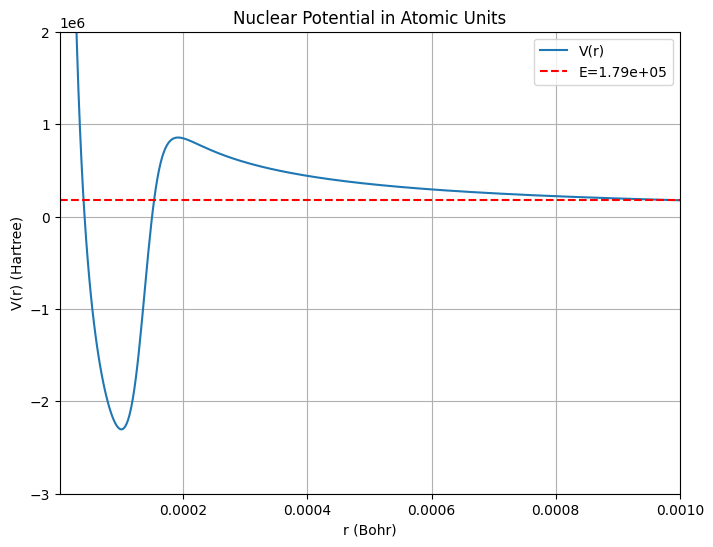

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import brentq

# -----------------------------------------------------------------------------
# 1. Global Definitions and Parameters (in atomic units)
# -----------------------------------------------------------------------------

ALPHA_MASS_AU = 7294.0     # alpha particle mass in me
AU_TIME_TO_S = 2.418884e-17  # 1 a.u. of time -> seconds

# -----------------------------
# Input Parameters
# -----------------------------
Z_parent    = 88          # parent nucleus charge (Radium)
E_hartree   = 1.79e5      # alpha particle energy for Radium (Hartree) ~ 5 MeV => ~ 1.84e5 Hartree
V0_hartree  = 4.3e6       # Woods-Saxon depth ~ 50 MeV => ~ 1.84e6 Hartree
R0_bohr     = 13.7e-5     # ~ 5 fm => ~ 9.45e-5 Bohr
a_bohr      = 1.3e-5      # diffuseness (Bohr) ~ 0.65 fm => ~ 1.23e-5 Bohr
l_orbital   = 0           # orbital angular momentum
r_min       = 1e-6        # inner bohr-radius
r_max       = 5e-3        # outer bohr-radius
N           = 2000        # number of points for scanning turning points

# -----------------------------------------------------------------------------
# 2. Potential: Woods-Saxon + Coulomb in a.u.
# -----------------------------------------------------------------------------
def V_WS_Coulomb_au(r, V0, R0, a, Z_nuc, Zalpha=2, mass_alpha=ALPHA_MASS_AU, l=0):
    """
    Woods-Saxon + Coulomb + optional centrifugal term in atomic units.
    """
    if r < 1e-12:
        r = 1e-12
    
    # Woods-Saxon
    Vws = -V0 / (1.0 + np.exp((r - R0)/a))
    # Coulomb
    Vcoul = Zalpha * Z_nuc / r
    # Centrifugal
    Vcentrif = l*(l+1)/(2.0*mass_alpha*r*r)
    return Vws + Vcoul + Vcentrif

# Potential Wrapper
def potential_au(r):
    return V_WS_Coulomb_au(r,
                           V0=V0_hartree,
                           R0=R0_bohr,
                           a=a_bohr,
                           Z_nuc=Z_parent,
                           Zalpha=2,
                           mass_alpha=ALPHA_MASS_AU,
                           l=l_orbital)

# -----------------------------------------------------------------------------
# 3. WKB and Classical Integrand Functions
# -----------------------------------------------------------------------------
def forbidden_integrand(r, E, m_alpha, pot_func):
    """
    Calculates the square root for the WKB integral
    sqrt(2*m_alpha*(V(r)-E)) if V(r)>E, else 0
    """
    val = pot_func(r) - E
    return np.sqrt(2*m_alpha*val) if val > 0 else 0.0

def classical_integrand(r, E, m_alpha, pot_func):
    """
    Calculates inverse velocity in the classical region
    1 / v(r) = sqrt(m_alpha/(2*(E - V(r)))) if E>V(r), else 0
    """
    val = E - pot_func(r)
    return np.sqrt(m_alpha/(2*val)) if val > 0 else 0.0

# -----------------------------------------------------------------------------
# 4. Helper Functions
# -----------------------------------------------------------------------------
def find_turning_points(r_min, r_max, E, pot_func, N=2000):
    r_vals = np.linspace(r_min, r_max, N)
    diff = E - np.array([pot_func(rv) for rv in r_vals])
    
    turning_pts = []
    for i in range(len(r_vals)-1):
        if diff[i]*diff[i+1] < 0:
            root = brentq(lambda rr: E - pot_func(rr), r_vals[i], r_vals[i+1])
            turning_pts.append(root)
    turning_pts.sort()
    return turning_pts

def detect_barrier_hill(E, turning_points, r_min, r_max, pot_func):
    """
    Looks for the pattern (+)->(-)->(+) in E-V(r)
    Returns the last such (r_in, r_out) if found
    """
    boundaries = [r_min] + turning_points + [r_max]
    signs = []
    for i in range(len(boundaries)-1):
        mid = 0.5*(boundaries[i] + boundaries[i+1])
        val_mid = E - pot_func(mid)
        s = 1 if val_mid > 0 else -1
        signs.append(s)
    
    hill_intervals = []
    for i in range(len(signs)-2):
        if signs[i] == 1 and signs[i+1] == -1 and signs[i+2] == 1:
            hill_start = boundaries[i+1]
            hill_end   = boundaries[i+2]
            hill_intervals.append((hill_start, hill_end))
    
    if hill_intervals:
        return hill_intervals[-1]
    return None

def compute_WKB_barrier_integral(r_in, r_out, E, m_alpha, pot_func):
    val, _ = quad(lambda rr: forbidden_integrand(rr, E, m_alpha, pot_func),
                  r_in, r_out, epsabs=1e-12, epsrel=1e-12, limit=1000)
    return val

def find_well_region(E, turning_points, r_min, r_max, pot_func):
    """
    Finds the first sub-interval [r_a, r_b] where E>V(r)
    """
    boundaries = [r_min] + turning_points + [r_max]
    for i in range(len(boundaries)-1):
        left = boundaries[i]
        right = boundaries[i+1]
        mid = 0.5*(left + right)
        if (E - pot_func(mid)) > 0:
            return (left, right)
    return None

def compute_classical_period(r_a, r_b, E, m_alpha, pot_func):
    single_trip, _ = quad(lambda rr: classical_integrand(rr, E, m_alpha, pot_func),
                          r_a, r_b, epsabs=1e-12, epsrel=1e-12, limit=1000)
    return 2.0 * single_trip

from scipy.optimize import root_scalar

def wkb_quantization_integral(E_trial, m, pot_func, n, r_min, r_max):
    """
    Function whose root corresponds to energy levels satisfying the
    Born–Sommerfeld quantization condition:
        ∫ sqrt(2m(E - V(r))) dr = (n + 1/2) * π
    """

    turning_points = find_turning_points(r_min, r_max, E_trial, pot_func)
    if len(turning_points) < 2:
        return np.nan  # Not enough turning points → skip

    r1, r2 = turning_points[0], turning_points[1]
    integrand = lambda r: np.sqrt(2 * m * (E_trial - pot_func(r))) if (E_trial - pot_func(r)) > 0 else 0.0

    try:
        integral_val, _ = quad(integrand, r1, r2, epsabs=1e-12, epsrel=1e-12, limit=1000)
        return integral_val - (n + 0.5) * np.pi
    except Exception as e:
        return np.nan


# -----------------------------------------------------------------------------
# 5. Troubleshooting
# -----------------------------------------------------------------------------

# Evaluates the potential on a grid to see if there's a barrier above E
r_dense = np.linspace(r_min, r_max, 2000)
V_dense = np.array([potential_au(rv) for rv in r_dense])

# Prints min/max of potential
V_min = np.min(V_dense)
V_max = np.max(V_dense)
print("Troubleshooting Info:")
print(f"  r_min = {r_min}, r_max = {r_max}")
print(f"  V_min over this range = {V_min:.4e} Hartree")
print(f"  V_max over this range = {V_max:.4e} Hartree")
print(f"  E (alpha energy)      = {E_hartree:.4e} Hartree")

# Checks if E is bigger than V_max or smaller than V_min
if E_hartree > V_max:
    print("E is ABOVE the maximum potential => no barrier (region with V>E)")
if E_hartree < V_min:
    print("E is BELOW the entire potential => might only have 1 crossing or none")

# Sample a few points in E - V(r) to determine sign
sample_indices = [0, len(r_dense)//2, len(r_dense)-1]
print("\nSample checks of sign(E - V(r)) at a few points:")
for idx in sample_indices:
    rr = r_dense[idx]
    val = E_hartree - V_dense[idx]
    sign_str = "+" if val>0 else "-"
    print(f"  r={rr:.4e}, V(r)={V_dense[idx]:.4e}, E-V={val:.4e} ({sign_str})")

# -----------------------------------------------------------------------------
# 6. Main Calculation
# -----------------------------------------------------------------------------
print("\n-- Attempting to detect barrier & compute WKB --")

turning_pts = find_turning_points(r_min, r_max, E_hartree, potential_au, N=N)
print(f"Turning points found (Bohr radii): {turning_pts}")

barrier = detect_barrier_hill(E_hartree, turning_pts, r_min, r_max, potential_au)
if barrier is None:
    raise ValueError("No barrier (hill) detected.")
r_in, r_out = barrier
print(f"Barrier region: r_in={r_in:.4e}, r_out={r_out:.4e}")

barrier_integral = compute_WKB_barrier_integral(r_in, r_out, E_hartree, ALPHA_MASS_AU, potential_au)
P_tunnel = np.exp(-2.0 * barrier_integral)

well_region = find_well_region(E_hartree, turning_pts, r_min, r_max, potential_au)
if well_region is None:
    raise ValueError("No well region found (E < V everywhere?).")
r_a, r_b = well_region
T_au = compute_classical_period(r_a, r_b, E_hartree, ALPHA_MASS_AU, potential_au)
T_s = T_au * AU_TIME_TO_S
Gamma_s = (1.0 / T_s) * P_tunnel
t_half_s = np.log(2) / Gamma_s

print("\n-- Results --")
print(f"WKB barrier integral = {barrier_integral:.6e}")
print(f"Tunneling probability = {P_tunnel:.3e}")
print(f"Well region: r_a={r_a:.4e}, r_b={r_b:.4e}")
print(f"Classical period T_au = {T_au:.4e} => T_s={T_s:.4e} s")
print(f"Decay rate Gamma = {Gamma_s:.4e} s^-1")
print(f"Half-life t_1/2 = {t_half_s:.4e} s")

# -----------------------------------------------------------------------------
# 7. Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.plot(r_dense, V_dense, label='V(r)')
plt.axhline(E_hartree, color='r', linestyle='--', label=f'E={E_hartree:.2e}')
plt.xlabel('r (Bohr)')
plt.ylabel('V(r) (Hartree)')
plt.title('Nuclear Potential in Atomic Units')
plt.grid(True)
plt.legend()
plt.xlim(1e-6, 1e-3)
plt.ylim(-3e6, 2e6)
plt.show()

# Literature value for Ra-226: 1600 year = 5e+10 s

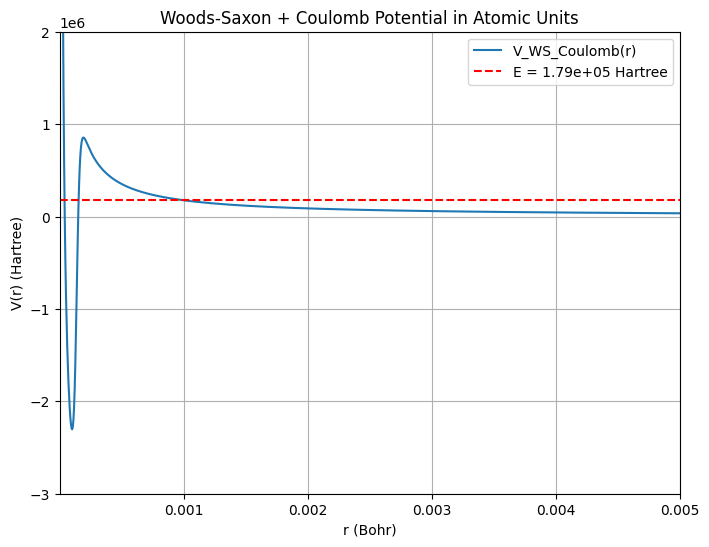


Born–Sommerfeld Approximation Quantization Levels
n=0: No level found in tested range
n=1: No level found in tested range
n=2: No level found in tested range
n=3: No level found in tested range
n=4: No level found in tested range


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.linalg import lapack

# =============================================================================
# 1. Global Definitions and Parameters (Atomic Units)
# =============================================================================
ALPHA_MASS_AU = 7294.0  # Alpha particle mass in atomic units
AU_TIME_TO_S = 2.418884e-17  # Atomic unit of time to seconds conversion

Z_parent    = 88          # parent nucleus charge (Radium)
E_hartree   = 1.79e5      # alpha particle energy for Radium (Hartree) ~ 5 MeV => ~ 1.84e5 Hartree
V0_hartree  = 4.3e6       # Woods-Saxon depth ~ 50 MeV => ~ 1.84e6 Hartree
R0_bohr     = 13.7e-5     # ~ 5 fm => ~ 9.45e-5 Bohr
a_bohr      = 1.3e-5      # diffuseness (Bohr) ~ 0.65 fm => ~ 1.23e-5 Bohr
l_orbital   = 0           # orbital angular momentum
r_min       = 1e-6        # inner bohr-radius
r_max       = 5e-3        # outer bohr-radius
N           = 2000        # number of points for scanning turning points


# =============================================================================
# 2. Woods-Saxon + Coulomb Potential (Atomic Units)
# =============================================================================
def V_WS_Coulomb_au(r, V0, R0, a, Z_nuc, Zalpha=2, mass_alpha=ALPHA_MASS_AU, l=0):
    if r < 1e-12:
        r = 1e-12
    Vws = -V0 / (1.0 + np.exp((r - R0)/a))
    Vcoul = Zalpha * Z_nuc / r
    Vcentrif = l * (l + 1) / (2.0 * mass_alpha * r * r)
    return Vws + Vcoul + Vcentrif

def potential_au(r):
    return V_WS_Coulomb_au(r, V0=V0_hartree, R0=R0_bohr, a=a_bohr, Z_nuc=Z_parent, Zalpha=2, mass_alpha=ALPHA_MASS_AU, l=l_orbital)

# =============================================================================
# 3. Hamiltonian Construction
# =============================================================================
def construct_hamiltonian(hamiltonian, overlap_mat):
    f1 = np.ones([n_inter, LegPoints], dtype=float)
    v_pot = np.zeros([n_inter, LegPoints], dtype=complex if resonances else float)
    for i in range(n_inter):
        for l in range(LegPoints):
            v_pot[i, l] = potential_au(x_grid[i, l])
    for i in range(basis_dim):
        for j in range(basis_dim):
            hamiltonian[i, j] = integral_u_upp(bf[i], bf[j])[0] / (-2.0 * mass) + integral_u_u(bf[i], bf[j], v_pot)[0]
            overlap_mat[i, j] = integral_u_u(bf[i], bf[j], f1)[0]

# =============================================================================
# 4. Plotting the Potential
# =============================================================================
def plot_potential():
    r_vals = np.linspace(r_min, r_max, 1000)
    V_vals = np.array([potential_au(rv) for rv in r_vals])
    plt.figure(figsize=(8,6))
    plt.plot(r_vals, V_vals, label='V_WS_Coulomb(r)')
    plt.axhline(E_hartree, color='r', linestyle='--', label=f'E = {E_hartree:.2e} Hartree')
    plt.xlabel('r (Bohr)')
    plt.ylabel('V(r) (Hartree)')
    plt.title('Woods-Saxon + Coulomb Potential in Atomic Units')
    plt.legend()
    plt.grid(True)
    plt.xlim(r_min, r_max)
    plt.ylim(-3e6, 2e6)
    plt.show()

# =============================================================================
# 5. Born–Sommerfeld Quantization Rule
# =============================================================================
def born_sommerfeld_quantization(E, m, potential, r_min, r_max):
    def p(r):
        val = E - potential(r)
        return np.sqrt(2 * m * val) if val > 0 else 0.0

    turning_points = []
    r_vals = np.linspace(r_min, r_max, 2000)
    diff = E - np.array([potential(rv) for rv in r_vals])
    for i in range(len(r_vals) - 1):
        if diff[i] * diff[i+1] < 0:
            root = brentq(lambda r: E - potential(r), r_vals[i], r_vals[i+1])
            turning_points.append(root)

    if len(turning_points) < 2:
        return None  # no quantized state

    r1, r2 = turning_points[0], turning_points[1]
    action, _ = quad(p, r1, r2, epsabs=1e-10, epsrel=1e-10, limit=1000)
    return action / np.pi  # compare to (n + 1/2) * hbar = (n + 1/2)

# =============================================================================
# 6. Execution: Run Main Code
# =============================================================================
if __name__ == "__main__":
    plot_potential()
    print("\nBorn–Sommerfeld Approximation Quantization Levels")
    for n in range(5):
        target = (n + 0.5)
        E_try = 1e5  # starting guess
        found = False
        for E_test in np.linspace(1e5, 5e5, 500):
            S_over_pi = born_sommerfeld_quantization(E_test, ALPHA_MASS_AU, potential_au, 1e-6, 5e-3)
            if S_over_pi is None:
                continue
            if abs(S_over_pi - target) < 0.1:
                print(f"n={n}, E ≈ {E_test:.4e} Hartree, S/pi = {S_over_pi:.3f}")
                found = True
                break
        if not found:
            print(f"n={n}: No level found in tested range")


# Application

Medicine, energy generation, cancer treatment, detectors, environmental monitoring, and materials science are all areas where alpha decay finds applications. 

In this notebook, we will focus on the operating principle of Radioisotope Thermoelectric Generators (RTGs), where alpha decay plays a central role. In an RTG, the energy released by the spontaneous emission of alpha particles from radioactive isotopes is converted into heat. When an alpha-emitting isotope, such as Plutonium-238, undergoes decay, each emitted alpha particle carries significant kinetic energy, which is absorbed by the surrounding material and transformed into thermal energy. This heat is then converted into electricity using thermocouples through the Seebeck effect. Unlike nuclear fission reactors, alpha decay does not produce neutrons or sustain a chain reaction; instead, it provides a continuous and reliable heat source over long periods. RTGs leverage this property to supply power in environments where conventional energy sources are impractical, such as deep-space missions or remote installations.

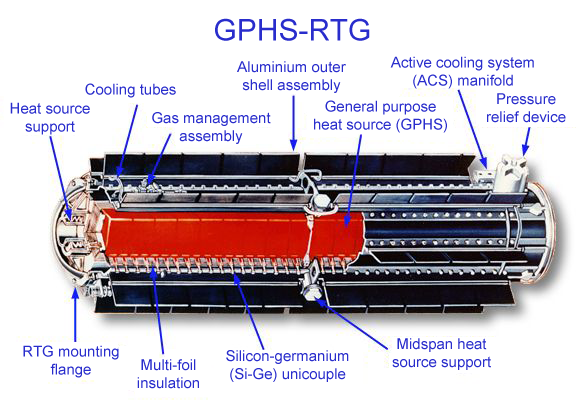

RTGs are particularly suitable as energy sources for autonomous systems located far from conventional power grids, where a few tens to hundreds of watts are needed over very long durations—far longer than typical batteries or fuel cells can provide.

For example, RTGs have been used to power spacecraft such as the Voyager probes, the Mars Curiosity rover, and the New Horizons mission to Pluto, providing reliable electricity for instruments and communication systems in deep space where solar power is insufficient.

## Problem:

A Radioisotope Thermoelectric Generator contains 1 kg of Plutonium-238 ($^{238} \text{Pu}$) with a half-life of 87.7 years. The energy released during the alpha decay of a single nucleus is 5.593 MeV. The generator’s thermocouples convert the thermal energy into electricity with an efficiency of 6%.

- Calculate the thermal power produced by 1 kg of Plutonium-238.

- Determine the electrical power output of the RTG.

- If the RTG is used to power electronics on a spacecraft, calculate how its power output will change after 10 years.

Parameters used:

- Mass of Plutonium-238: $m$ = 1 kg

- Half-life: $T_{1/2}$ = 87.7 years

- Energy per alpha particle: $E_{\alpha}$ = 5.593 MeV

- Thermocouple efficiency: $\eta =6\% = 0.06$

Step 1: Calculate the number of atoms in 1 kg of Plutonium-238

Molar mass of Pu-238: 
$$M = 0.238 \text{kg/mol}$$

Number of atoms: 
$$ N = \frac{m}{M} N_A $$


Step 2: Calculate the decay constant

$$ \lambda = \frac{\ln{2}}{T_{1/2}} $$

Step 3: Radioactive decay law: Number of undecayed nuclei at time $t$:

$$N(t) = N_0 \exp^{-\lambda t}$$

Step 4: Calculate the thermal power (energy per decay × decays per second)

at $t = 0$

$$P_{heat} = \lambda \cdot N_0 \cdot E_{\alpha}$$

with time dependence:

$$P_{heat}(t) = \lambda \cdot N_0\exp^{-\lambda t}  \cdot E_{\alpha}$$

Step 5: Electrical power, if the thermoelectric efficiency is $\eta$:

$$P_{el} = \eta \cdot P_{heat}$$ 

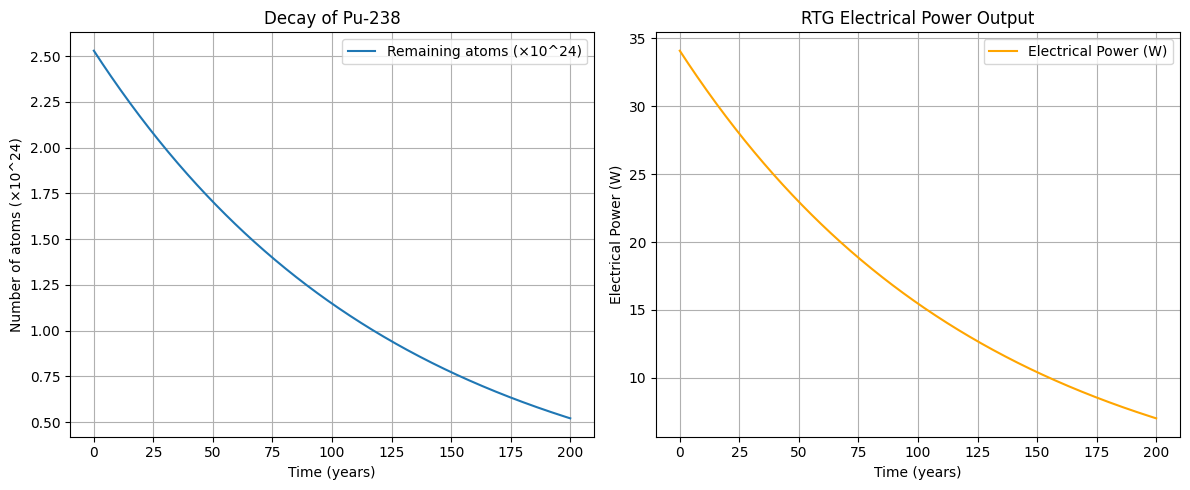

In [18]:
import math
import matplotlib.pyplot as plt
import numpy as np

m = 1.0  # kg of Plutonium-238
M = 0.238  # kg/mol
N_A = 6.022e23  # Avogadro's number
T_half_years = 87.7  # half-life in years
E_alpha_MeV = 5.593  # energy per alpha particle in MeV
eta = 0.06  # thermocouple efficiency

seconds_per_year = 365 * 24 * 3600
T_half_sec = T_half_years * seconds_per_year

E_alpha_J = E_alpha_MeV * 1.602e-13

# Initial number of atoms
N0 = (m / M) * N_A

# Decay constant
lambda_decay = math.log(2) / T_half_sec

# Time array (0 to 200 years)
years = np.linspace(0, 200, 500)
seconds = years * seconds_per_year

# Number of atoms over time
N_t = N0 * np.exp(-lambda_decay * seconds)

# Thermal and electrical power over time
P_heat_t = lambda_decay * N_t * E_alpha_J
P_elec_t = eta * P_heat_t

# Plot results
plt.figure(figsize=(12,5))

# Plot number of atoms vs years
plt.subplot(1,2,1)
plt.plot(years, N_t/1e24, label="Remaining atoms (×10^24)")
plt.xlabel("Time (years)")
plt.ylabel("Number of atoms (×10^24)")
plt.title("Decay of Pu-238")
plt.grid(True)
plt.legend()

# Plot electrical power vs years
plt.subplot(1,2,2)
plt.plot(years, P_elec_t, color="orange", label="Electrical Power (W)")
plt.xlabel("Time (years)")
plt.ylabel("Electrical Power (W)")
plt.title("RTG Electrical Power Output")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import math

m = 1.0              # kg of Plutonium-238
M = 0.238            # kg/mol
N_A = 6.022e23       # Avogadro's number
T_half_years = 87.7  # half-life in years
E_alpha_MeV = 5.593  # energy per alpha particle in MeV
eta = 0.06           # thermocouple efficiency

seconds_per_year = 365 * 24 * 3600
T_half_sec = T_half_years * seconds_per_year
E_alpha_J = E_alpha_MeV * 1.602e-13


# Number of atoms
N = (m / M) * N_A

# Decay constant
lambda_decay = math.log(2) / T_half_sec

# Thermal power
P_heat = lambda_decay * N * E_alpha_J

# Electrical power
P_elec = eta * P_heat

# Power after 10 years
t_years = 10
t_sec = t_years * seconds_per_year

P_heat_10yr = P_heat * math.exp(-lambda_decay * t_sec)
P_elec_10yr = eta * P_heat_10yr

# Results
print(f"Thermal power: {P_heat:.1f} W")
print(f"Electrical power: {P_elec:.1f} W")
print(f"Thermal power after 10 years: {P_heat_10yr:.1f} W")
print(f"Electrical power after 10 years: {P_elec_10yr:.1f} W")


Thermal power: 568.2 W
Electrical power: 34.1 W
Thermal power after 10 years: 525.0 W
Electrical power after 10 years: 31.5 W


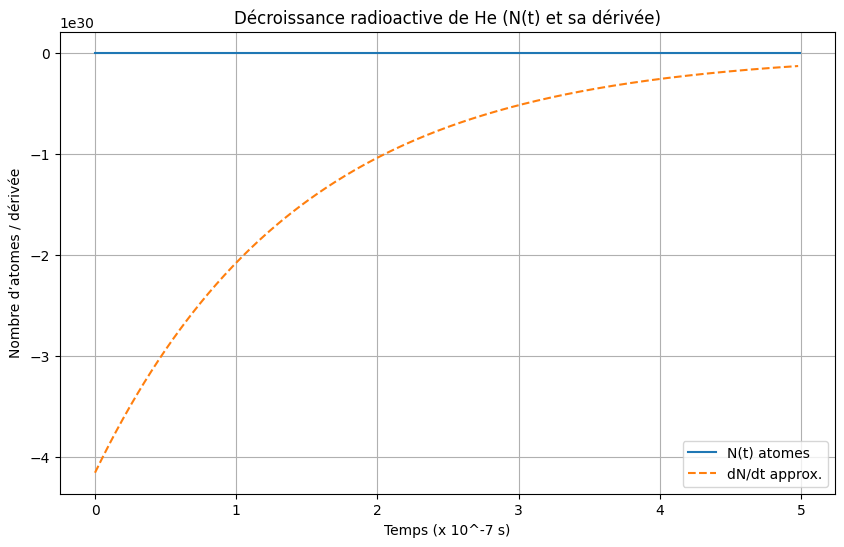

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
T_half = 1e-7               # demi-vie en secondes
lambda_decay = np.log(2) / T_half
N0 = 6.022e23               # nombre d’atomes pour 1 mole
t_max = 5e-7                # temps max (quelques demi-vies)
dt = 1e-9                   # pas de temps pour la dérivée

# Vecteur temps
t = np.arange(0, t_max, dt)

# Loi de décroissance
N = N0 * np.exp(-lambda_decay * t)

# Dérivée approchée (avant dernière valeur)
dN_dt_approx = (N[1:] - N[:-1]) / dt

# Pour aligner avec t, on prend t sans le dernier point
t_deriv = t[:-1]

# Tracé
plt.figure(figsize=(10,6))

plt.plot(t*1e7, N, label="N(t) atomes")
plt.plot(t_deriv*1e7, dN_dt_approx, label="dN/dt approx.", linestyle='--')

plt.xlabel("Temps (x 10^-7 s)")
plt.ylabel("Nombre d’atomes / dérivée")
plt.title("Décroissance radioactive de He (N(t) et sa dérivée)")
plt.legend()
plt.grid(True)
plt.show()

Geiger Counter Simulation:
Time  0s:  1 counts 🔊
Time  1s:  1 counts 🔊
Time  2s:  2 counts 🔊🔊
Time  3s:  3 counts 🔊🔊🔊
Time  4s:  1 counts 🔊
Time  5s:  0 counts 
Time  6s:  1 counts 🔊
Time  7s:  2 counts 🔊🔊
Time  8s:  0 counts 
Time  9s:  0 counts 
Time 10s:  0 counts 
Time 11s:  3 counts 🔊🔊🔊
Time 12s:  0 counts 
Time 13s:  1 counts 🔊
Time 14s:  3 counts 🔊🔊🔊
Time 15s:  0 counts 
Time 16s:  0 counts 
Time 17s:  0 counts 
Time 18s:  1 counts 🔊
Time 19s:  0 counts 
Time 20s:  0 counts 
Time 21s:  1 counts 🔊
Time 22s:  3 counts 🔊🔊🔊
Time 23s:  0 counts 
Time 24s:  0 counts 
Time 25s:  2 counts 🔊🔊
Time 26s:  0 counts 
Time 27s:  1 counts 🔊
Time 28s:  0 counts 
Time 29s:  0 counts 
Time 30s:  2 counts 🔊🔊
Time 31s:  0 counts 
Time 32s:  0 counts 
Time 33s:  2 counts 🔊🔊
Time 34s:  2 counts 🔊🔊
Time 35s:  2 counts 🔊🔊
Time 36s:  1 counts 🔊
Time 37s:  0 counts 
Time 38s:  0 counts 
Time 39s:  0 counts 
Time 40s:  0 counts 
Time 41s:  0 counts 
Time 42s:  0 counts 
Time 43s:  3 counts 🔊🔊🔊
Time 44s:  

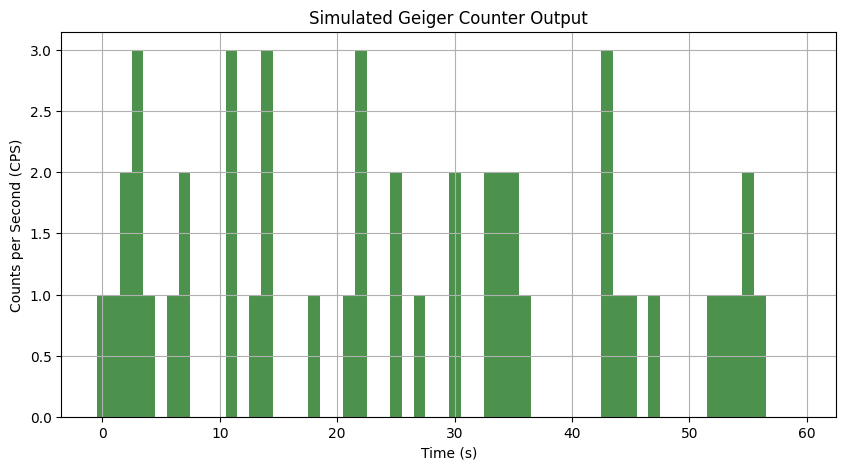

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
T_half = 9.49e+5  # seconds (you can change to match a real isotope)
N0 = 1e6     # initial number of radioactive atoms
duration = 60  # seconds
dt = 0.01    # time step (s)
dead_time = 0.002  # seconds - Geiger counter "recovery time"

# --- Derived values ---
lambda_decay = np.log(2) / T_half
num_steps = int(duration / dt)
time = np.linspace(0, duration, num_steps)
N = N0 * np.exp(-lambda_decay * time)  # true decay curve

# Simulate decay detections with Poisson noise + dead time
detections = np.zeros(num_steps)
last_detection_time = -np.inf

for i in range(num_steps):
    expected_decays = N[i] * lambda_decay * dt
    if (time[i] - last_detection_time) >= dead_time:
        count = np.random.poisson(expected_decays)
        if count > 0:
            detections[i] = 1  # mark detection
            last_detection_time = time[i]

# Sum counts per second for plotting
time_bins = np.arange(0, duration + 1, 1)
cps, _ = np.histogram(time[detections == 1], bins=time_bins)

# --- Output: text + plot ---
print("Geiger Counter Simulation:")
for sec, count in enumerate(cps):
    print(f"Time {sec:2d}s: {count:2d} counts", "🔊" * min(count, 20))

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.bar(time_bins[:-1], cps, width=1.0, alpha=0.7, color='darkgreen')
plt.xlabel("Time (s)")
plt.ylabel("Counts per Second (CPS)")
plt.title("Simulated Geiger Counter Output")
plt.grid(True)
plt.show()
